In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["DATA_PATH"] = "../assets/"

In [2]:
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src.game.wrapped_flappy_bird import GameState
from src.models.DoubleDQN import DoubleDQN, QualityEstimator, policy

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pygame 2.4.0 (SDL 2.26.4, Python 3.10.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
config = {
    "sessions_num": 1000,
    "gamma": 1.001,
    "lr": 1e-3,
    "state_dim": 7,
    "action_dim": 2,
    "hid_dim": [30, 30, 30, 16],
    "epsion": 1e-2,
    "temperature": 10
}

GAMMA = config["gamma"]
EPS = config["epsion"]
TEMP = config["temperature"]
SESSIONS_NUM = config["sessions_num"]

In [7]:
action_terminal = GameState()

model = QualityEstimator(
    config["state_dim"],
    config["action_dim"],
    config["hid_dim"]
)

optimizer = optim.Adam(model.parameters())

In [8]:
total_rewards = []

for session_idx in tqdm(range(SESSIONS_NUM)):
    
    terminal = False
    input_action = 0
    _, reward, terminal = action_terminal.frame_step(input_action)
    state = torch.tensor(list(action_terminal.state.values()), dtype=torch.float32)
    total_reward = 0.0
    while not terminal:
        model.zero_grad()
        
        predicted_actions_rewards = model(state)
        
        action, predicted_reward = policy(model, state, TEMP)
        _, reward, terminal = action_terminal.frame_step(action)
        state = torch.tensor(list(action_terminal.state.values()), dtype=torch.float32)
        with torch.no_grad():
            max_next_reward = torch.max(model(state))
        loss = (predicted_reward - (reward + GAMMA * max_next_reward)).pow(2)
        loss.backward()
        optimizer.step()
        total_reward += reward
        
    
    total_rewards += [total_reward]    

  0%|          | 0/250 [00:00<?, ?it/s]

[0.466974   0.53302604]
[0.5311564  0.46884358]
[0.57305574 0.42694423]
[0.5569985  0.44300148]
[0.5464862  0.45351383]
[0.5379472 0.4620529]
[0.52119625 0.47880378]
[0.5069673 0.4930327]
[0.49523452 0.5047655 ]
[0.48633736 0.51366264]
[0.47951803 0.52048206]
[0.48086435 0.51913565]
[0.48781085 0.51218915]
[0.49674204 0.50325793]
[0.5053963 0.4946037]
[0.5128601  0.48713982]
[0.51743746 0.48256257]
[0.5198836 0.4801165]
[0.5193793  0.48062062]
[0.51535034 0.48464966]
[0.50883335 0.4911667 ]
[0.50168735 0.49831268]
[0.49451506 0.505485  ]
[0.48898336 0.51101667]
[0.48664328 0.5133567 ]
[0.4875473 0.5124527]
[0.49021655 0.5097835 ]
[0.49413443 0.5058656 ]
[0.49855113 0.50144887]
[0.5018321 0.4981678]
[0.5041392  0.49586084]
[0.50614655 0.4938534 ]
[0.50702983 0.4929702 ]
[0.5064505  0.49354944]
[0.50456506 0.49543488]
[0.50244933 0.4975506 ]
[0.50022954 0.4997705 ]
[0.49879047 0.50120956]
[0.49711496 0.5028851 ]
[0.4961603 0.5038397]
[0.49549383 0.5045062 ]
[0.49557936 0.50442064]
[0.496

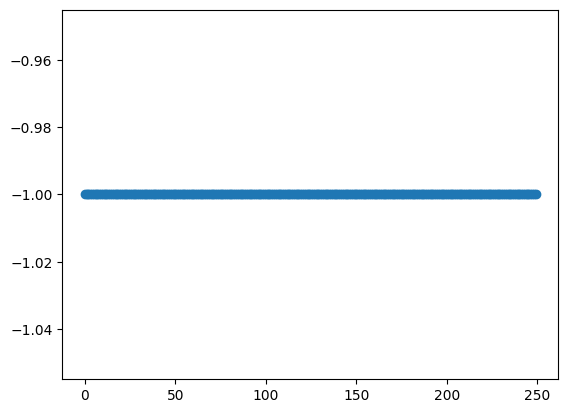

In [9]:
plt.scatter(range(len(total_rewards)), total_rewards)